## Bloque I
Descomprimir el csv en formato gz

In [10]:
"""  
Importación de ficheros de AIRBNB. Preprocesado y cargado a la base de datos 

Obtenemos los datos desde https://insideairbnb.com/get-the-data/

Podríamos hacer scraping, obtener la fecha de la última actualización de Madrid y generar el enlace para descargarlo, pero no es necesario por que se actualiza cada mucho tiempo y no es necesario tener la última versión. Podemos cambiar la info procesable en la carpeta data manualmente.

"""
import os
import pandas as pd
import numpy as np
import datetime
#from config_bd import *
import requests
import sys
import gzip
import shutil
import matplotlib.pyplot as plt


In [11]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score


In [13]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## Import Data
Carga del csv de detalle completo en pandas. Cambios de tipos e imputación

In [20]:
output_file_path = './data/transform_listings.csv'

In [21]:
df = pd.read_csv(output_file_path, low_memory=False)

In [22]:
df.columns

Index(['property_id', 'listing_url', 'name', 'description',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'aire',
       'garaje', 'calefaccion', 'ascensor'],
      dtype='object')

In [16]:
df

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,amenities,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d,aire,garaje,calefaccion,ascensor
0,70059,https://www.airbnb.com/rooms/70059,Tu hogar en centro de Madrid.,"Very nice, cozy and bright, right in the cente...",Universidad,Centro,40.423810,-3.710380,Entire rental unit,Entire home/apt,...,"[""Paid parking off premises"", ""Window AC unit""...",66.0,15,365,0,0.0,0,0,1,1
1,70310,https://www.airbnb.com/rooms/70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",Cozy Apartment in great location in the center...,Universidad,Centro,40.422520,-3.702500,Entire rental unit,Entire home/apt,...,"[""Portable fans"", ""Paid parking off premises"",...",89.0,30,360,0,0.0,0,0,1,0
2,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.411500,-3.704490,Entire rental unit,Entire home/apt,...,"[""Wifi"", ""Dishes and silverware"", ""Oven"", ""Hot...",173.0,3,180,102,17646.0,1,0,1,0
3,84719,https://www.airbnb.com/rooms/84719,Cool Apart. (10min Center + WIFI),Cool and confortable 1 bedroom apartment for 2...,Embajadores,Centro,40.408660,-3.703740,Entire rental unit,Entire home/apt,...,"[""Portable fans"", ""Pocket wifi"", ""Single level...",72.0,7,1125,0,0.0,1,0,1,1
4,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.409390,-3.698120,Entire rental unit,Entire home/apt,...,"[""Smoke alarm"", ""Pack \u2019n play/Travel crib...",189.0,3,365,144,27216.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,1368974630547284843,https://www.airbnb.com/rooms/1368974630547284843,Coqueto estudio en tetuan!,Disconnect from the routine in this charming a...,Valdeacederas,Tetuán,40.464951,-3.704578,Entire rental unit,Entire home/apt,...,"[""Air conditioning"", ""Pets allowed"", ""Wifi"", ""...",67.0,5,365,0,0.0,1,0,0,0
13867,1368981094706864086,https://www.airbnb.com/rooms/1368981094706864086,Bonito estudio en Tetuán!,Get away from routine at this unique and relax...,Valdeacederas,Tetuán,40.468355,-3.706939,Entire rental unit,Entire home/apt,...,"[""Air conditioning"", ""Pets allowed"", ""Wifi"", ""...",63.0,5,365,0,0.0,1,0,0,0
13868,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",Canillas,Hortaleza,40.464110,-3.647130,Entire rental unit,Entire home/apt,...,"[""Cleaning available during stay"", ""Wifi"", ""Wi...",103.0,2,365,0,0.0,1,0,1,1
13869,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,San Isidro,Carabanchel,40.395983,-3.730953,Entire rental unit,Entire home/apt,...,"[""Pets allowed"", ""Kitchen"", ""TV"", ""Air conditi...",100.0,5,365,0,0.0,1,0,0,0


In [17]:
df.shape

(13871, 23)

Eliminamos campos innecesarios que a priori no nos sirven

In [18]:
df = df.drop(columns=['scrape_id','last_scraped','source','neighborhood_overview','host_id','host_url','host_name','host_since','host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','bathrooms_text','beds','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','availability_eoy','number_of_reviews_ly','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_about','host_neighbourhood','calendar_updated','availability_30','availability_60','availability_90','availability_365','picture_url'])

KeyError: "['scrape_id', 'last_scraped', 'source', 'neighborhood_overview', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'bathrooms_text', 'beds', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_about', 'host_neighbourhood', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'picture_url'] not found in axis"

Eliminamos las habitaciones, casas compartidas, hoteles, etc, solo queremos VIVIENDAS COMPLETAS

In [ ]:
# df['property_type'].value_counts()
# df['room_type'].value_counts()

df = df[df['room_type']== 'Entire home/apt'].copy()
df['room_type'].value_counts()

room_type
Entire home/apt    16805
Name: count, dtype: int64

conversión de tipos

In [ ]:
df['accommodates'] = df['accommodates'].astype(int)
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['maximum_nights'] = df['maximum_nights'].astype(int)
df['estimated_occupancy_l365d'] = df['estimated_occupancy_l365d'].astype(int)

imputamos una habitación y un baño cuando esta información no está rellena, asumiendo que habiendo retirado las propiedades compartidas, podemos interpretar que los estudios, lofts, etc todos van a tener al menos una habitación y baño o equivalente. (Sofá cama, etc).

*También se podría imputar las habitaciones dividiendo los "acommodates" entre dos pero creo que este método es más conservador.*

In [ ]:
df

,id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,amenities,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d
1,30320,https://www.airbnb.com/rooms/30320,Great Vacational Apartments,NaN,Sol,Centro,40.414760,-3.704180,Entire rental unit,Entire home/apt,2,0,1,"[""Kitchen"", ""Air conditioning"", ""Elevator"", ""T...",NaN,5,180,0,NaN
2,30959,https://www.airbnb.com/rooms/30959,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,Embajadores,Centro,40.412590,-3.701050,Entire loft,Entire home/apt,2,0,1,"[""Shampoo"", ""Smoking allowed"", ""Pets allowed"",...",NaN,3,730,0,NaN
3,40916,https://www.airbnb.com/rooms/40916,Holiday Apartment Madrid Center,NaN,Universidad,Centro,40.422470,-3.705770,Entire rental unit,Entire home/apt,3,0,1,"[""Pets allowed"", ""Kitchen"", ""TV"", ""Air conditi...",NaN,5,180,0,NaN
5,70059,https://www.airbnb.com/rooms/70059,Tu hogar en centro de Madrid.,"Very nice, cozy and bright, right in the cente...",Universidad,Centro,40.423810,-3.710380,Entire rental unit,Entire home/apt,2,1,1,"[""Paid parking off premises"", ""Window AC unit""...",66.0,15,365,0,0.0
6,70310,https://www.airbnb.com/rooms/70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",Cozy Apartment in great location in the center...,Universidad,Centro,40.422520,-3.702500,Entire rental unit,Entire home/apt,2,1,1,"[""Portable fans"", ""Paid parking off premises"",...",89.0,30,360,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,1368974630547284843,https://www.airbnb.com/rooms/1368974630547284843,Coqueto estudio en tetuan!,Disconnect from the routine in this charming a...,Valdeacederas,Tetuán,40.464951,-3.704578,Entire rental unit,Entire home/apt,2,1,1,"[""Air conditioning"", ""Pets allowed"", ""Wifi"", ""...",67.0,5,365,0,0.0
25282,1368981094706864086,https://www.airbnb.com/rooms/1368981094706864086,Bonito estudio en Tetuán!,Get away from routine at this unique and relax...,Valdeacederas,Tetuán,40.468355,-3.706939,Entire rental unit,Entire home/apt,2,1,1,"[""Air conditioning"", ""Pets allowed"", ""Wifi"", ""...",63.0,5,365,0,0.0
25283,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",Canillas,Hortaleza,40.464110,-3.647130,Entire rental unit,Entire home/apt,3,1,1,"[""Cleaning available during stay"", ""Wifi"", ""Wi...",103.0,2,365,0,0.0
25284,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,San Isidro,Carabanchel,40.395983,-3.730953,Entire rental unit,Entire home/apt,5,1,2,"[""Pets allowed"", ""Kitchen"", ""TV"", ""Air conditi...",100.0,5,365,0,0.0


In [ ]:
# df[(df['bathrooms'] == 0)& (df['bedrooms']==0)]
df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

In [ ]:
df = df.rename(columns={'id':'property_id'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16805 entries, 1 to 25285
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  amenit

#### Data Import of Rentas Ayto Madrid

In [ ]:
#Import data from Ayto de Madrid, rentas
df_rentas = pd.read_csv('../ayto_madrid/Datos_Rentas_Madrid_2022.csv',delimiter=";")
df_rentas.head()

,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,01. Centro,20.587,41.059,28.500,22.05,27.030,53.908
1,02. Arganzuela,21.383,49.236,31.038,28.35,27.431,63.160
2,03. Retiro,25.407,60.762,37.916,31.85,33.396,79.868
3,04. Salamanca,28.140,64.925,42.592,31.15,38.751,89.407
4,05. Chamartín,30.506,74.842,47.564,34.65,42.678,104.706


In [ ]:
df_rentas.dtypes

Distrito                                           object
Renta neta media por persona                      float64
Renta neta media por hogar                        float64
Media de la renta neta por unidad de consumo      float64
Mediana de la renta neta por unidad de consumo    float64
Renta bruta media por persona                     float64
Renta media bruta por hogar                       float64
dtype: object

In [ ]:
for col in df_rentas.select_dtypes(include='float'):
    df_rentas[col] = df_rentas[col].apply(lambda x: x * 1000)

df_rentas.head()


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,01. Centro,20587.0,41059.0,28500.0,22050.0,27030.0,53908.0
1,02. Arganzuela,21383.0,49236.0,31038.0,28350.0,27431.0,63160.0
2,03. Retiro,25407.0,60762.0,37916.0,31850.0,33396.0,79868.0
3,04. Salamanca,28140.0,64925.0,42592.0,31150.0,38751.0,89407.0
4,05. Chamartín,30506.0,74842.0,47564.0,34650.0,42678.0,104706.0


In [ ]:
df['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Salamanca', 'Arganzuela', 'Fuencarral - El Pardo',
       'Chamberí', 'Chamartín', 'Carabanchel', 'Puente de Vallecas',
       'Hortaleza', 'Moncloa - Aravaca', 'Tetuán', 'Retiro',
       'San Blas - Canillejas', 'Barajas', 'Moratalaz', 'Ciudad Lineal',
       'Villaverde', 'Latina', 'Vicálvaro', 'Villa de Vallecas', 'Usera'],
      dtype=object)

In [ ]:
df_rentas['Distrito'].unique()

array(['01. Centro', '02. Arganzuela', '03. Retiro', '04. Salamanca',
       '05. Chamartín', '06. Tetuán', '07. Chamberí',
       '08. Fuencarral-El Pardo', '09. Moncloa-Aravaca', '10. Latina',
       '11. Carabanchel', '12. Usera', '13. Puente de Vallecas',
       '14. Moratalaz', '15. Ciudad Lineal', '16. Hortaleza',
       '17. Villaverde', '18. Villa de Vallecas', '19. Vicálvaro',
       '20. San Blas-Canillejas', '21. Barajas'], dtype=object)

In [ ]:
df_rentas['Distrito'] = df_rentas['Distrito'].str[4:]
df_rentas['Distrito'] = df_rentas['Distrito'].apply(lambda x: x.replace('-', ' - ') if '-' in x else x)
df_rentas.head(21)


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,Centro,20587.0,41059.0,28500.0,22050.0,27030.0,53908.0
1,Arganzuela,21383.0,49236.0,31038.0,28350.0,27431.0,63160.0
2,Retiro,25407.0,60762.0,37916.0,31850.0,33396.0,79868.0
3,Salamanca,28140.0,64925.0,42592.0,31150.0,38751.0,89407.0
4,Chamartín,30506.0,74842.0,47564.0,34650.0,42678.0,104706.0
5,Tetuán,18062.0,42465.0,25955.0,20650.0,22890.0,53816.0
6,Chamberí,27076.0,60032.0,40145.0,31150.0,36934.0,81889.0
7,Fuencarral - El Pardo,21947.0,58214.0,34241.0,28350.0,28798.0,76386.0
8,Moncloa - Aravaca,26694.0,68238.0,41666.0,30450.0,36592.0,93541.0
9,Latina,14375.0,35669.0,20833.0,18550.0,17267.0,42843.0


In [ ]:
print(sorted(df['neighbourhood_group_cleansed'].unique()))
print(sorted(df_rentas['Distrito'].unique()))

['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín', 'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza', 'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde']
['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín', 'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza', 'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde']


## Functions

In [ ]:
from xgboost import XGBRegressor 

models = {"lr":linear_model.LinearRegression(),
          "ridge":linear_model.Ridge(alpha=0),
          "lasso":linear_model.Lasso(),
          "SGD":linear_model.SGDRegressor(),
          "HuberRegressor":linear_model.HuberRegressor(),
          "Elastic":linear_model.ElasticNet(),
          "XGBRegressor":XGBRegressor()}


def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = metrics.mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = metrics.r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
    return pd.DataFrame(metrics_analysis)


df_rentas['renta_bin'] = pd.cut(
    df_rentas['Renta neta media por hogar'].sort_values(),
    bins=5,
    labels=['muy_bajo','bajo','medio','alto','muy_alto'],
    include_lowest=True
)
df_rentas[['Distrito', 'Renta neta media por hogar', 'renta_bin']]


def get_renta_bin(distrito:str):
    # Busca el distrito en df_rentas y devuelve el valor de 'renta_bin'
    row = df_rentas[df_rentas['Distrito'] == distrito]
    if not row.empty:
        return row['renta_bin'].values[0]
    else:
        return None
    

## Funciones para calcular distancia minima a la estacion del metro
from math import radians, sin, cos, sqrt, atan2

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


def get_nearest_metro_distance(row, df_metro):
    min_distance = float('inf')
    for _, metro_row in df_metro.iterrows():
        distance = haversine(row['longitude'], row['latitude'], metro_row['stop_lon'], metro_row['stop_lat'])
        if distance < min_distance:
            min_distance = distance
    return min_distance
#####

## Understand Data, Get More Data and Clean data
Importamos a la base de datos. 
**Requiere haber creado la tabla** <code>01_CREATE TABLE bnb_property.sql</code>

In [ ]:
#from config_bd import get_connection

In [ ]:
#df.to_csv(os.path.join(TEMP_DIR,'transform_listings.csv'), index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16805 entries, 1 to 25285
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  amenit

### Property type and room_type

Filter to consider only the property type that correct

In [ ]:
df["property_type"].value_counts()

property_type
Entire rental unit           14881
Entire condo                   549
Entire loft                    512
Entire home                    356
Entire serviced apartment      322
Entire guesthouse               23
Entire guest suite              22
Tiny home                       22
Entire place                    21
Entire vacation home            20
Camper/RV                       16
Entire townhouse                15
Casa particular                 10
Entire villa                     8
Entire chalet                    7
Entire home/apt                  5
Room in aparthotel               4
Floor                            4
Entire cabin                     3
Religious building               2
Hut                              1
Entire bungalow                  1
Yurt                             1
Name: count, dtype: int64

Anteriormente seleccionnado los registros con room_type =  'Entire home/apt'.
Ahora quitamos los registros que no se corresponden a una vivienda en funcion del room_type

In [ ]:
property_types_to_remove = ['Camper/RV', 'Room in aparthotel', 'Entire cabin','Hut','Yurt','Entire Bungalow']
df = df[~df['property_type'].isin(property_types_to_remove)].copy()

In [ ]:
df['property_type'].value_counts()

property_type
Entire rental unit           14881
Entire condo                   549
Entire loft                    512
Entire home                    356
Entire serviced apartment      322
Entire guesthouse               23
Tiny home                       22
Entire guest suite              22
Entire place                    21
Entire vacation home            20
Entire townhouse                15
Casa particular                 10
Entire villa                     8
Entire chalet                    7
Entire home/apt                  5
Floor                            4
Religious building               2
Entire bungalow                  1
Name: count, dtype: int64

In [ ]:
df[['accommodates','bedrooms','bathrooms']]

,accommodates,bedrooms,bathrooms
1,2,1,1
2,2,1,1
3,3,1,1
5,2,1,1
6,2,1,1
...,...,...,...
25281,2,1,1
25282,2,1,1
25283,3,1,1
25284,5,2,1


### Amenities

In [ ]:
import ast

def get_all_amenities(data):
    """
    Devuelve un set con todos los amenities únicos presentes en la columna 'amenities' del DataFrame.
    """
    all_amenities = set()
    for amenities_str in data["amenities"]:
        try:
            amenities_list = ast.literal_eval(amenities_str)
            all_amenities.update(amenities_list)
        except Exception:
            continue
    return all_amenities

In [ ]:
amenities = get_all_amenities(df)

In [ ]:
len(amenities)

2881

In [ ]:
# df['aire'] = df['amenities'].apply(lambda x: 1 if '"Air conditioning"' in x else 0)
# df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)
# df['ascensor'] = df['amenities'].apply(lambda x: 1 if '"Elevator"' in x else 0)

In [ ]:
amentities_exclude = ['condition','pool','BBQ','sauna','conditioner','Exercise equipment','Paid Parking','sound system','Housekeeping','book','amazon','soap','shampoo','hair dryer','iron','washer','dryer','TV','internet','wifi','kitchen','microwave','refrigerator','stove','oven','dishwasher','coffee maker','toaster']

In [ ]:
for exclude_amenity in amentities_exclude:
     amenities = [value for value in amenities if str.lower(exclude_amenity) not in str.lower(value)]


In [ ]:
len(amenities)

245

In [ ]:
amenities

['AC - split type ductless system',
 'Paid crib - available upon request',
 'Coffee',
 'Ceiling fan',
 'Game console: Xbox One',
 'Building staff',
 'Window guards',
 'Property manager',
 'Standalone high chair - always at the listing',
 'Movie theater',
 'Garden view',
 'Freezer',
 'Clothing storage: walk-in closet and wardrobe',
 'Board games',
 'Shared gym nearby',
 'Bay view',
 'Baby safety gates',
 'Paid resort access',
 'Shared backyard – Not fully fenced',
 'Clamp on table seat high chair',
 'Desert view',
 'Harbor view',
 'Game console',
 'City skyline view',
 'Game console: PS5',
 'Valley view',
 'Barbecue utensils',
 'Backyard - Fully fenced',
 'Game console: PS3',
 'Paid standalone high chair - available upon request',
 'Clothing storage: walk-in closet and dresser',
 'Golf course view',
 'High chair - available upon request',
 'Safe',
 'EV charger',
 'Booster seat high chair',
 'Private backyard – Not fully fenced',
 'Lake access',
 'Gym in building',
 'Outdoor playground',

##### Heating

In [ ]:
[value for value in amenities if 'heating' in str.lower(value)]

['Heating - split type ductless system',
 'Radiant heating',
 'Heating',
 'Central heating']

In [ ]:
df['calefaccion'] = df['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)

In [ ]:
df['calefaccion'].value_counts()

calefaccion
1    14459
0     2321
Name: count, dtype: int64

##### Pool

In [ ]:
[value for value in amenities if ('pool' in str.lower(value)) and ('whirlpool' not in str.lower(value)) and ('whirpool' not in str.lower(value))]

[]

- Pool

In [ ]:
df['pool'] = df['amenities'].apply(lambda x: 1 if ('pool' in str.lower(x)) and ('whirlpool' not in str.lower(x)) and ('whirpool' not in str.lower(x)) else 0)

In [ ]:
df['pool'].value_counts()

pool
0    16022
1      758
Name: count, dtype: int64

##### Parking

In [ ]:
[value for value in amenities if 'free parking' in str.lower(value)]

['Free parking garage on premises – 81 spaces',
 'Free parking garage on premises – 1 space',
 'Free parking on premises – 1 space',
 'Free parking garage on premises – 17 spaces',
 'Free parking garage on premises – 2 spaces',
 'Free parking garage on premises – 51 spaces',
 'Free parking on premises',
 'Free parking garage on premises',
 'Free parking garage on premises – 45 spaces']

In [ ]:
df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)

In [ ]:
df['garaje'].value_counts()

garaje
0    15842
1      938
Name: count, dtype: int64

##### Air conditioning

In [ ]:
[value for value in amenities if 'air conditi' in str.lower(value)]

[]

In [ ]:
df['aire_acondicionado'] = df['amenities'].apply(lambda x: 1 if 'air conditi' in str.lower(x) else 0)

In [ ]:
df['aire_acondicionado'].value_counts()

aire_acondicionado
1    12281
0     4499
Name: count, dtype: int64

##### Elevator

In [ ]:
[value for value in amenities if 'elevator' in str.lower(value)]

['Elevator']

In [ ]:
df['ascensor'] = df['amenities'].apply(lambda x: 1 if 'elevator' in str.lower(x) else 0)

In [ ]:
df['ascensor'].value_counts()

ascensor
0    8621
1    8159
Name: count, dtype: int64

##### Movilidad reducida

In [ ]:
[value for value in amenities if 'single level home' in str.lower(value)]

['Single level home']

In [ ]:
df['movilidad_reducida'] = df['amenities'].apply(lambda x: 1 if 'single level home' in str.lower(x) else 0)

In [ ]:
df['movilidad_reducida'].value_counts()

movilidad_reducida
0    14899
1     1881
Name: count, dtype: int64

In [ ]:
#OJO, no tiene sentido no tener ascensor y movilidad reducida
df[df['movilidad_reducida'] == 1][["listing_url","movilidad_reducida","ascensor"]]

,listing_url,movilidad_reducida,ascensor
9,https://www.airbnb.com/rooms/84719,1,1
37,https://www.airbnb.com/rooms/684564,1,1
72,https://www.airbnb.com/rooms/280733,1,1
78,https://www.airbnb.com/rooms/751527,1,1
80,https://www.airbnb.com/rooms/752424,1,1
...,...,...,...
25131,https://www.airbnb.com/rooms/1362319075445033257,1,0
25135,https://www.airbnb.com/rooms/1366625139989288134,1,1
25188,https://www.airbnb.com/rooms/1367400865560226670,1,1
25200,https://www.airbnb.com/rooms/1365826061924320510,1,0


### Otros

Columna "name_description" , nos sirve para recoger mas datos y eliminar duplicados

In [ ]:
df["name_description"] = df["name"].fillna(" ").str.lower() + " and " + df["description"].fillna(" ").str.lower()
df["name_description"].isnull().sum()


0

##### Terrace

In [ ]:
df["terraza"] = df["name_description"].apply(lambda x: 1 if "terrace" in x else 0)

In [ ]:
df["terraza"].value_counts()

terraza
0    15405
1     1375
Name: count, dtype: int64

##### Balconies

In [ ]:
df["balcon"] = df["name_description"].apply(lambda x: 1 if "balcon" in x else 0)

In [ ]:
df["balcon"].value_counts()

balcon
0    15734
1     1046
Name: count, dtype: int64

In [ ]:
df[ (df['description'].str.contains('terrace', na=False))]

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,estimated_revenue_l365d,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,name_description,terraza,balcon
7,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.411500,-3.704490,Entire rental unit,Entire home/apt,...,17646.0,1,0,0,1,0,0,sunny attic duplex flat with terrace next to s...,1,0
10,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.409390,-3.698120,Entire rental unit,Entire home/apt,...,27216.0,1,0,0,1,1,0,cozy attic with intimate rooftop terrace+ elev...,1,0
20,100411,https://www.airbnb.com/rooms/100411,Ático muy luminoso,Penthouse with a beautiful terrace and expansi...,Valverde,Fuencarral - El Pardo,40.500440,-3.670320,Entire rental unit,Entire home/apt,...,NaN,1,1,1,0,1,0,ático muy luminoso and penthouse with a beauti...,1,0
27,198296,https://www.airbnb.com/rooms/198296,Very quiet central top floor with 2 terraces,Beautiful central top floor apartment with two...,Universidad,Centro,40.425890,-3.705650,Entire rental unit,Entire home/apt,...,5100.0,1,0,0,0,1,0,very quiet central top floor with 2 terraces a...,1,0
85,760482,https://www.airbnb.com/rooms/760482,Dúplex-Penthouse Cuzco-Castellana Smart,The flat is very spacious having 100 square me...,Castillejos,Tetuán,40.459890,-3.694720,Entire rental unit,Entire home/apt,...,NaN,1,0,0,1,1,0,dúplex-penthouse cuzco-castellana smart and th...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24938,1360059324279556027,https://www.airbnb.com/rooms/1360059324279556027,Luxury apartment in Chamartín by beBalmy,Elegant 115 m2 apartment with large terrace an...,Castilla,Chamartín,40.467512,-3.686079,Entire rental unit,Entire home/apt,...,0.0,1,0,0,1,1,0,luxury apartment in chamartín by bebalmy and e...,1,0
25181,1367208187303882310,https://www.airbnb.com/rooms/1367208187303882310,Central Sol residences 5-I,This listing has a strategic location - it wil...,Cortes,Centro,40.415140,-3.700600,Entire rental unit,Entire home/apt,...,0.0,0,0,0,1,0,0,central sol residences 5-i and this listing ha...,1,0
25189,1367400905039791308,https://www.airbnb.com/rooms/1367400905039791308,La Terraza Vista Alegre,Modern 1-Bedroom with Terrace in Vista Alegre ...,Vista Alegre,Carabanchel,40.390433,-3.742443,Entire rental unit,Entire home/apt,...,0.0,1,0,0,1,0,0,la terraza vista alegre and modern 1-bedroom w...,1,0
25272,1368903492306099065,https://www.airbnb.com/rooms/1368903492306099065,Edgar Neville III,"Bathed in natural light, this stylish apartmen...",Cuatro Caminos,Tetuán,40.450625,-3.695489,Entire rental unit,Entire home/apt,...,0.0,1,0,0,1,0,0,"edgar neville iii and bathed in natural light,...",1,0


##### Jardin

In [ ]:
df["jardin"] = df["name_description"].apply(lambda x: 1 if "garden" in x else 0)

In [ ]:
df["jardin"].value_counts()
#Columna no concluyente, garden view...

jardin
0    16464
1      316
Name: count, dtype: int64

In [ ]:
df[df['jardin'] == 1][["listing_url","jardin","description"]]
df[df['jardin'] == 1][["listing_url","jardin","description"]]

,listing_url,jardin,description
79,https://www.airbnb.com/rooms/751530,1,"Modern apartment, comfortable in the center of..."
83,https://www.airbnb.com/rooms/755587,1,"Modern, comfortable apartment in the middle of..."
94,https://www.airbnb.com/rooms/761159,1,"Modern, comfortable apartment in the heart of ..."
166,https://www.airbnb.com/rooms/923140,1,It is our Home when are in Madrid<br />Whole h...
248,https://www.airbnb.com/rooms/1256157,1,"Situated in the vibrant La Latina neighborhod,..."
...,...,...,...
24435,https://www.airbnb.com/rooms/1344736366819913608,1,This studio is situated in an unbeatable locat...
24829,https://www.airbnb.com/rooms/1355647187610947785,1,"Renovated family house in Chamartin, near the ..."
24993,https://www.airbnb.com/rooms/1360726822768311194,1,Seasonal rental in the heart of Madrid.<br /><...
24995,https://www.airbnb.com/rooms/1360745730432902867,1,"1 bedroom and 1 bathroom apartment, with 45 m2..."


##### Meters

In [ ]:
df[(df["name_description"].str.contains("0m"))][["listing_url","name_description"]]

,listing_url,name_description
2,https://www.airbnb.com/rooms/30959,beautiful loft in madrid center and beautiful ...
9,https://www.airbnb.com/rooms/84719,cool apart. (10min center + wifi) and cool and...
41,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...
53,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...
73,https://www.airbnb.com/rooms/281224,the royal palace opera central apartment and a...
...,...,...
24920,https://www.airbnb.com/rooms/1359649495299627125,piso de un dormitorio en tetuan and get away f...
24951,https://www.airbnb.com/rooms/1360101264409120935,apartamento de 1 dormitorio - oshun valdecanil...
25021,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...
25046,https://www.airbnb.com/rooms/1364476792835645609,monthly 3br 2bth 6 beds and this cozy and grea...


In [ ]:
df[(df["name_description"].str.contains(" m2 ")) | (df["name_description"].str.contains("m2"))][["listing_url","name_description"]]

,listing_url,name_description
2,https://www.airbnb.com/rooms/30959,beautiful loft in madrid center and beautiful ...
41,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...
53,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...
121,https://www.airbnb.com/rooms/449218,"central, fully equipped, best price and locate..."
148,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...
...,...,...
24938,https://www.airbnb.com/rooms/1360059324279556027,luxury apartment in chamartín by bebalmy and e...
24985,https://www.airbnb.com/rooms/1363706454959121782,toque de madrid para 8 en tesoro 6 and several...
24995,https://www.airbnb.com/rooms/1360745730432902867,apartamento en chamartín and 1 bedroom and 1 b...
25021,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...


In [ ]:
df[(df["name_description"].str.contains(" m² ")) | (df["name_description"].str.contains("m²"))][["listing_url","name_description"]]

,listing_url,name_description
166,https://www.airbnb.com/rooms/923140,penhouse with lovely terrace and it is our hom...
357,https://www.airbnb.com/rooms/2650925,"amazing plaza mayor view, apt in the city cent..."
358,https://www.airbnb.com/rooms/2652829,"charming plaza mayor view, city center apt in ..."
488,https://www.airbnb.com/rooms/3584830,rooftop in the heart of madrid - plaza mayor v...
506,https://www.airbnb.com/rooms/3610905,appartment in malasaña and a 70m² renewed apar...
...,...,...
24951,https://www.airbnb.com/rooms/1360101264409120935,apartamento de 1 dormitorio - oshun valdecanil...
24977,https://www.airbnb.com/rooms/1363628607171548582,house of arts - la latina and the <b>apartment...
25073,https://www.airbnb.com/rooms/1361514406168377855,"modern, brand-new apartment for 4 in las letra..."
25169,https://www.airbnb.com/rooms/1365318262628960289,"encanto madrileño para 2, vive en calle del ág..."


In [ ]:
import re
def get_meters(data):
    """
    Devuelve un set con todos los metros únicos presentes en la columna 'name_description' del DataFrame.
    """
    matches_1 = re.findall(r'(\d+)\s?m²', data)
    matches_2 = re.findall(r'(\d+)\s?m2', data)
    if matches_1:
        return int(matches_1[0])
    if matches_2:
        return int(matches_2[0])

    return None

In [ ]:
df["meters"] = df["name_description"].apply(get_meters)

In [ ]:
df[~df["meters"].isnull()][["listing_url","name_description","meters","price","estimated_occupancy_l365d","estimated_revenue_l365d"]]

,listing_url,name_description,meters,price,estimated_occupancy_l365d,estimated_revenue_l365d
2,https://www.airbnb.com/rooms/30959,beautiful loft in madrid center and beautiful ...,60.0,NaN,0,NaN
41,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...,110.0,177.0,48,8496.0
53,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...,40.0,100.0,14,1400.0
121,https://www.airbnb.com/rooms/449218,"central, fully equipped, best price and locate...",25.0,64.0,255,16320.0
148,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...,45.0,114.0,192,21888.0
...,...,...,...,...,...,...
25021,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...,50.0,103.0,0,0.0
25046,https://www.airbnb.com/rooms/1364476792835645609,monthly 3br 2bth 6 beds and this cozy and grea...,90.0,251.0,0,0.0
25073,https://www.airbnb.com/rooms/1361514406168377855,"modern, brand-new apartment for 4 in las letra...",75.0,182.0,0,0.0
25169,https://www.airbnb.com/rooms/1365318262628960289,"encanto madrileño para 2, vive en calle del ág...",50.0,92.0,0,0.0


In [ ]:
df.sort_values(by=['price'], ascending=False)

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,name_description,terraza,balcon,jardin,meters
17547,1087700981397177073,https://www.airbnb.com/rooms/1087700981397177073,Stunning duplex | Terrace & BBQ | Free Parking,Discover our duplex in the North Zone of Madri...,Valdeacederas,Tetuán,40.467680,-3.708650,Entire rental unit,Entire home/apt,...,0,1,1,1,0,stunning duplex | terrace & bbq | free parking...,1,0,0,NaN
7887,45249073,https://www.airbnb.com/rooms/45249073,Captivating Apartment in Madrid near El Retiro...,Detach yourself from work commitments and fami...,Palomeras Bajas,Puente de Vallecas,40.391400,-3.664250,Entire rental unit,Entire home/apt,...,0,0,1,0,0,captivating apartment in madrid near el retiro...,0,1,0,NaN
2602,18816591,https://www.airbnb.com/rooms/18816591,PUERTA DEL ANGEL,"Located next to Paseo De Extremadura, a few me...",Puerta del Angel,Latina,40.409160,-3.732560,Entire rental unit,Entire home/apt,...,0,0,1,1,0,puerta del angel and located next to paseo de ...,1,0,1,NaN
15022,942610520665563520,https://www.airbnb.com/rooms/942610520665563520,Piso en goya,Break up with your day-to-day life and relax i...,Ibiza,Retiro,40.421349,-3.675481,Entire rental unit,Entire home/apt,...,0,0,1,0,0,piso en goya and break up with your day-to-day...,0,0,0,NaN
23767,1321793225986456129,https://www.airbnb.com/rooms/1321793225986456129,Historic Center 3 bedroom apartment-1 min to m...,"Modern apartment in Madrid’s Historic Center, ...",Cortes,Centro,40.413740,-3.699030,Entire rental unit,Entire home/apt,...,0,0,1,0,0,historic center 3 bedroom apartment-1 min to m...,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24691,1354194465663087161,https://www.airbnb.com/rooms/1354194465663087161,White and Green,"Enjoy this cozy apartment, it is perfect for s...",Palacio,Centro,40.411582,-3.710897,Entire rental unit,Entire home/apt,...,0,0,0,0,0,"white and green and enjoy this cozy apartment,...",0,0,0,NaN
24743,1354556068197939987,https://www.airbnb.com/rooms/1354556068197939987,#StudioPlazaCastilla/wifi/A/C#,"Cozy one bedroom apartment, short walk to Vald...",Valdeacederas,Tetuán,40.466819,-3.705450,Entire home,Entire home/apt,...,0,0,1,0,0,#studioplazacastilla/wifi/a/c# and cozy one be...,0,0,0,NaN
24745,1354584586110919472,https://www.airbnb.com/rooms/1354584586110919472,# #StudioPlazaCastiilla/wifi/A/C,"Cozy one bedroom apartment, short walk to Vald...",Valdeacederas,Tetuán,40.467468,-3.706808,Entire home,Entire home/apt,...,0,0,1,0,0,# #studioplazacastiilla/wifi/a/c and cozy one ...,0,0,0,NaN
24746,1354593678560108749,https://www.airbnb.com/rooms/1354593678560108749,# # #StudioPlazaCastilla/Wifi/,"Cozy one-bedroom apartment is rented, a short ...",Valdeacederas,Tetuán,40.465700,-3.705790,Entire home,Entire home/apt,...,0,0,1,0,0,# # #studioplazacastilla/wifi/ and cozy one-be...,0,0,0,NaN


### Duplicates

In [ ]:
df.shape

(16780, 30)

In [ ]:
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

name_description
flamenco style apartment | palacio real, la latina and wonderful apartment located just above one of the oldest flamenco tablao in madrid, the corral de la morería, recently renovated opting for quality and comfort, offering an incredible rest. located in one of the most central areas of madrid that offers a multitude of restaurants, leisure and culture a few steps from the nerve center of the city. it has a bedroom with a queen size bed, a sofa bed, complete kitchen and a bathroom. whether for leisure or work, enjoy your apartment!            14
home art madrid estudio estándar and this studio apartment has impeccable interior design. its modern style makes it one of the most practical. everything is paid to attention to every last detail. due to its unbeatable location and interior care, it is perfect to enjoy one of the most sought-after areas in madrid.                                                                                                                  

In [ ]:
df.drop_duplicates(subset=["name_description"], keep="first", inplace=True)

In [ ]:
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

Series([], Name: name_description, dtype: int64)

In [ ]:
df.shape

(16527, 30)

In [ ]:
df.isnull().sum()

property_id                         0
listing_url                         0
name                                0
description                       459
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
amenities                           0
price                            2901
minimum_nights                      0
maximum_nights                      0
estimated_occupancy_l365d           0
estimated_revenue_l365d          2901
calefaccion                         0
pool                                0
garaje                              0
aire_acondicionado                  0
ascensor                            0
movilidad_reducida                  0
name_description                    0
terraza     

In [ ]:
df.dtypes

property_id                       int64
listing_url                      object
name                             object
description                      object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
amenities                        object
price                           float64
minimum_nights                    int64
maximum_nights                    int64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64


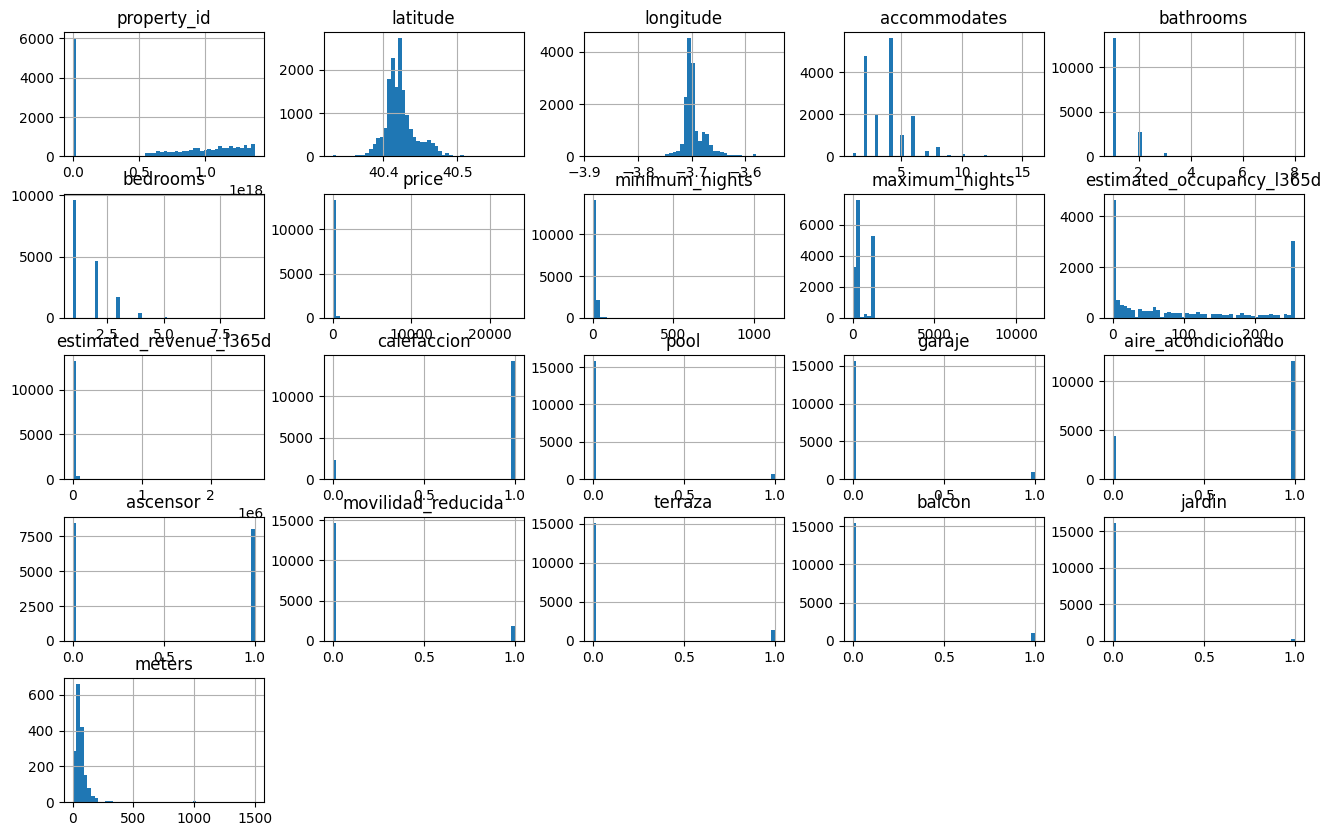

In [ ]:
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(16, 10))
plt.show()

In [ ]:
num_columns = df.select_dtypes(exclude='object').columns
num_columns

Index(['property_id', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms', 'price', 'minimum_nights', 'maximum_nights',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'calefaccion',
       'pool', 'garaje', 'aire_acondicionado', 'ascensor',
       'movilidad_reducida', 'terraza', 'balcon', 'jardin', 'meters'],
      dtype='object')

In [ ]:
columns_to_drop = ['property_id','listing_url','name', 'description', 'name_description','neighbourhood_cleansed','amenities','minimum_nights','maximum_nights','room_type','property_type']
df.drop(columns=columns_to_drop, inplace=True)
df.columns

Index(['neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'calefaccion', 'pool', 'garaje',
       'aire_acondicionado', 'ascensor', 'movilidad_reducida', 'terraza',
       'balcon', 'jardin', 'meters'],
      dtype='object')

In [ ]:
df.isnull().sum()

neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
price                            2901
estimated_occupancy_l365d           0
estimated_revenue_l365d          2901
calefaccion                         0
pool                                0
garaje                              0
aire_acondicionado                  0
ascensor                            0
movilidad_reducida                  0
terraza                             0
balcon                              0
jardin                              0
meters                          14844
dtype: int64

In [ ]:
len(df)

16527

In [ ]:
df.dropna(subset=['price','estimated_revenue_l365d',], how='any', inplace=True)

In [ ]:
df.isnull().sum()

neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
price                               0
estimated_occupancy_l365d           0
estimated_revenue_l365d             0
calefaccion                         0
pool                                0
garaje                              0
aire_acondicionado                  0
ascensor                            0
movilidad_reducida                  0
terraza                             0
balcon                              0
jardin                              0
meters                          12208
dtype: int64

In [ ]:
len(df)

13626

### Movilidad Reducida

No tiene sentido, movilidad_reducida a 1 y no tener ascensor. Solo tendria sentido si el piso o casa esta en la planta baja o acceso directo desde la calle.
Eliminamos todos los registros en los que ocurra esto

In [ ]:
df = df[(df["movilidad_reducida"] == 1) & (df["ascensor"] == 1) | (df["movilidad_reducida"] == 0)]

In [ ]:
len(df)

12951

### neighbourhood_group_cleansed

In [ ]:
df['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Arganzuela', 'Chamberí', 'Fuencarral - El Pardo',
       'Hortaleza', 'Moncloa - Aravaca', 'Retiro',
       'San Blas - Canillejas', 'Barajas', 'Moratalaz', 'Ciudad Lineal',
       'Salamanca', 'Chamartín', 'Tetuán', 'Villaverde', 'Carabanchel',
       'Latina', 'Vicálvaro', 'Puente de Vallecas', 'Usera',
       'Villa de Vallecas'], dtype=object)

In [ ]:
df[['neighbourhood_group_cleansed','price']].groupby('neighbourhood_group_cleansed').count()

,price
neighbourhood_group_cleansed,
Arganzuela,642
Barajas,43
Carabanchel,325
Centro,6230
Chamartín,460
Chamberí,862
Ciudad Lineal,302
Fuencarral - El Pardo,112
Hortaleza,217


In [ ]:
#Calculate column 
df["price_pers"] = df['price'] / df["accommodates"]

<Axes: >

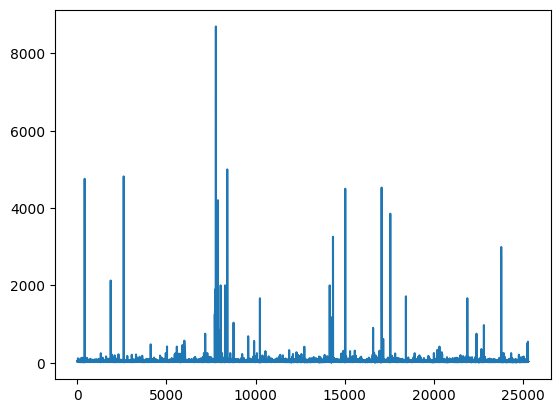

In [ ]:
df["price_pers"].plot()

In [ ]:
df.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
dtype: object

In [ ]:
df['neighbourhood_group_cleansed'].value_counts()

neighbourhood_group_cleansed
Centro                   6230
Salamanca                1048
Tetuán                    919
Chamberí                  862
Arganzuela                642
Retiro                    506
Chamartín                 460
Carabanchel               325
Ciudad Lineal             302
Puente de Vallecas        283
Moncloa - Aravaca         270
Hortaleza                 217
Usera                     202
San Blas - Canillejas     194
Latina                    194
Fuencarral - El Pardo     112
Villaverde                 67
Barajas                    43
Villa de Vallecas          34
Moratalaz                  25
Vicálvaro                  16
Name: count, dtype: int64

<Axes: xlabel='neighbourhood_group_cleansed'>

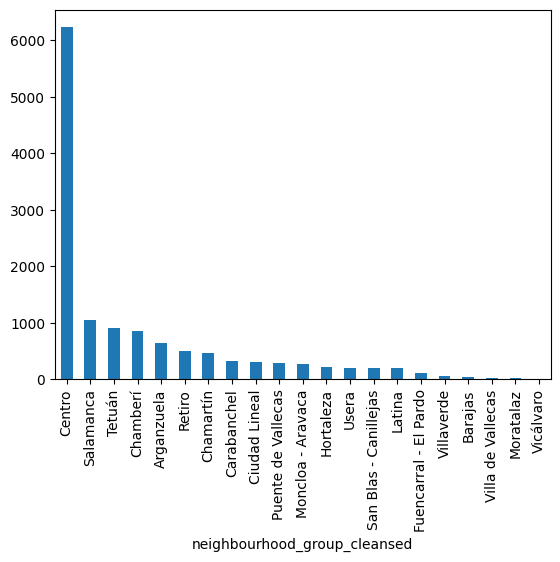

In [ ]:
df['neighbourhood_group_cleansed'].value_counts().plot.bar()

<Axes: xlabel='bedrooms'>

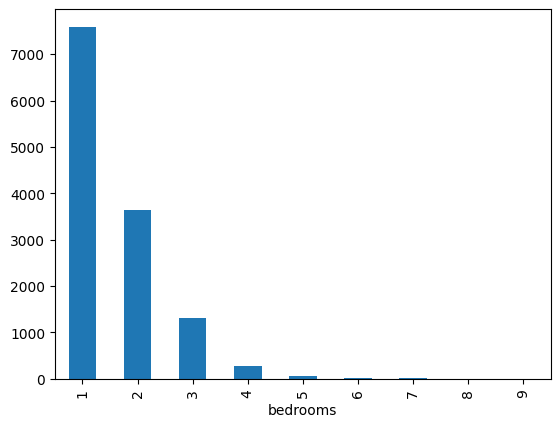

In [ ]:
df["bedrooms"].value_counts().plot.bar()

<Axes: xlabel='bathrooms'>

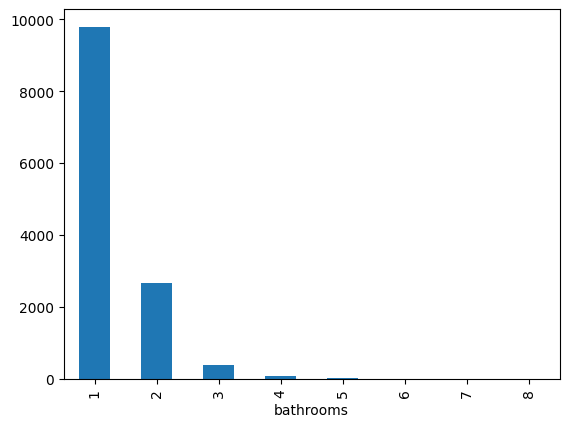

In [ ]:
df["bathrooms"].value_counts().plot.bar()

#### New Colunm distance_to_center

In [ ]:
center_lat, center_lon = 40.4168, -3.7038

# Create distance to city center
df['distance_to_center'] = np.sqrt((df['latitude'] - center_lat)**2 + (df['longitude'] - center_lon)**2)

#### New Column bath_bed_ratio

In [ ]:
df["bath_bed_ratio"] = df["bathrooms"] / df["bedrooms"]

#### New Column renta_bin

In [ ]:
df["renta_bin"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_renta_bin(x))

#### New Column es_Centro

In [ ]:
def get_es_Centro(neighbourhood):
    if neighbourhood == 'Centro':
        return 1
    return 0

In [ ]:
df["es_centro"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_es_Centro(x))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12951 entries, 5 to 25285
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12951 non-null  object 
 1   latitude                      12951 non-null  float64
 2   longitude                     12951 non-null  float64
 3   accommodates                  12951 non-null  int64  
 4   bathrooms                     12951 non-null  int64  
 5   bedrooms                      12951 non-null  int64  
 6   price                         12951 non-null  float64
 7   estimated_occupancy_l365d     12951 non-null  int64  
 8   estimated_revenue_l365d       12951 non-null  float64
 9   calefaccion                   12951 non-null  int64  
 10  pool                          12951 non-null  int64  
 11  garaje                        12951 non-null  int64  
 12  aire_acondicionado            12951 non-null  int64  
 13  ascens

#### New Column nearest_metro_distance

##### Dataframe metro_madrid paradas

In [ ]:
df_metro = pd.read_csv('../metro_madrid/stops.txt', delimiter=',')
df_metro.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,par_4_1,1,PLAZA DE CASTILLA,Paseo de la Castellana 189,40.46690,-3.68917,A,http://www.crtm.es,0,est_90_21,NaN,0
1,acc_4_1_1,1,Plaza de Castilla,Paseo de la Castellana 189,40.46682,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0
2,acc_4_1_1040,1,Ascensor,Plaza de Castilla 9,40.46555,-3.68877,NaN,http://www.crtm.es,2,est_90_21,NaN,0
3,acc_4_1_1043,1,Intercambiador Superficie,Paseo de la Castellana 191 B,40.46728,-3.68915,NaN,http://www.crtm.es,2,est_90_21,NaN,0
4,acc_4_1_1044,1,Ascensor,Paseo de la Castellana 189,40.46702,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0


##### Calculo de distancia Ubicacion Alojamiento - Estacion de Metro

In [ ]:
df['nearest_metro_distance'] = df.apply(lambda row: get_nearest_metro_distance(row, df_metro), axis=1)

#### Outliers

In [ ]:
df_numerics_Q1 = df[['price_pers']].apply(lambda x: np.quantile(x,q=.25)) # indicadores de Q1
df_numerics_Q3 = df[['price_pers']].apply(lambda x: np.quantile(x,q=.75)) # indicadores de Q2
df_numerics_IQR = df_numerics_Q3 - df_numerics_Q1 # longitud del IQR
df_numerics_lower = df_numerics_Q1 - 1.5 * df_numerics_IQR # limite inferior
df_numerics_upper = df_numerics_Q3 + 1.5 * df_numerics_IQR # limite superior
print(f"Outliers: Low:{df_numerics_lower} High:{df_numerics_upper}")

Outliers: Low:price_pers   -6.701923
dtype: float64 High:price_pers    79.221154
dtype: float64


In [ ]:
df.shape

(12951, 25)

In [ ]:
df_numerics_over_max = df[['price_pers']].apply(lambda x: x> df_numerics_upper,axis=1) # comprobamos que valores están por encima del máximo
df_numerics_below_min = df[['price_pers']].apply(lambda x: x< df_numerics_lower,axis=1) # comprobamos que valores están por encima del máximo
pd.DataFrame({"outlier_below":df_numerics_below_min.sum(),
              "outlier_above":df_numerics_over_max.sum()})

,outlier_below,outlier_above
price_pers,0,604


In [ ]:
samples_with_outliers_price_pers = df_numerics_below_min.any(axis=1) | df_numerics_over_max.any(axis=1)

In [ ]:
df_with_outliers = df[samples_with_outliers_price_pers]

<Axes: title={'center': 'Muestras con outliers'}, xlabel='bedrooms', ylabel='price_pers'>

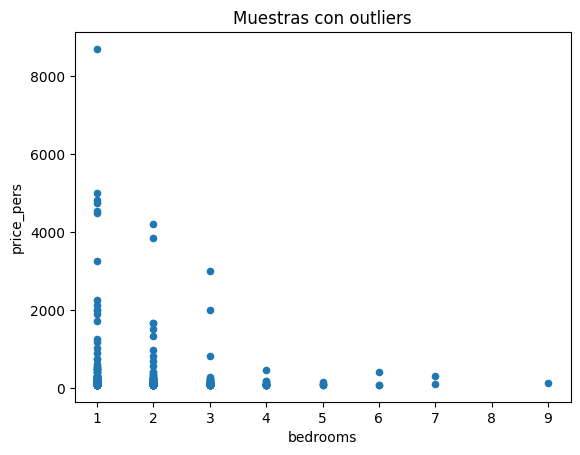

In [ ]:
# Exploración de las muestras con outliers,
df_with_outliers.plot.scatter(x="bedrooms",y="price_pers", title="Muestras con outliers")

<Axes: title={'center': 'Muestras sin outliers Clásicos'}, xlabel='bedrooms', ylabel='price_pers'>

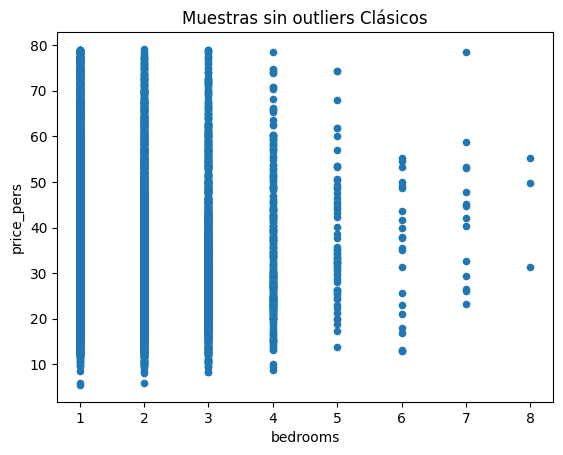

In [ ]:
# Exploración de las muestras sin outliers,
df[~samples_with_outliers_price_pers].plot.scatter(x="bedrooms",y="price_pers", title="Muestras sin outliers Clásicos")

In [ ]:
df = df[~samples_with_outliers_price_pers]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12347 entries, 5 to 25285
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12347 non-null  object 
 1   latitude                      12347 non-null  float64
 2   longitude                     12347 non-null  float64
 3   accommodates                  12347 non-null  int64  
 4   bathrooms                     12347 non-null  int64  
 5   bedrooms                      12347 non-null  int64  
 6   price                         12347 non-null  float64
 7   estimated_occupancy_l365d     12347 non-null  int64  
 8   estimated_revenue_l365d       12347 non-null  float64
 9   calefaccion                   12347 non-null  int64  
 10  pool                          12347 non-null  int64  
 11  garaje                        12347 non-null  int64  
 12  aire_acondicionado            12347 non-null  int64  
 13  ascens

## Models

Model not considerating meters, we are going to create a model to predict the price per night

### Model 007

renta_bin y distance_center y considerando otros outliers en precio

In [ ]:
dfm = df.copy()

In [ ]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [ ]:
dfm.shape

(12347, 25)

In [ ]:
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','garaje','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','jardin']]

In [ ]:
dfm.dtypes

bedrooms                int64
accommodates            int64
bathrooms               int64
price                 float64
renta_bin              object
garaje                  int64
ascensor                int64
pool                    int64
terraza                 int64
balcon                  int64
distance_to_center    float64
aire_acondicionado      int64
movilidad_reducida      int64
jardin                  int64
dtype: object

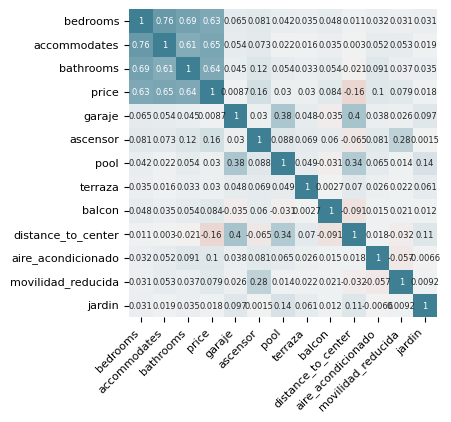

In [ ]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

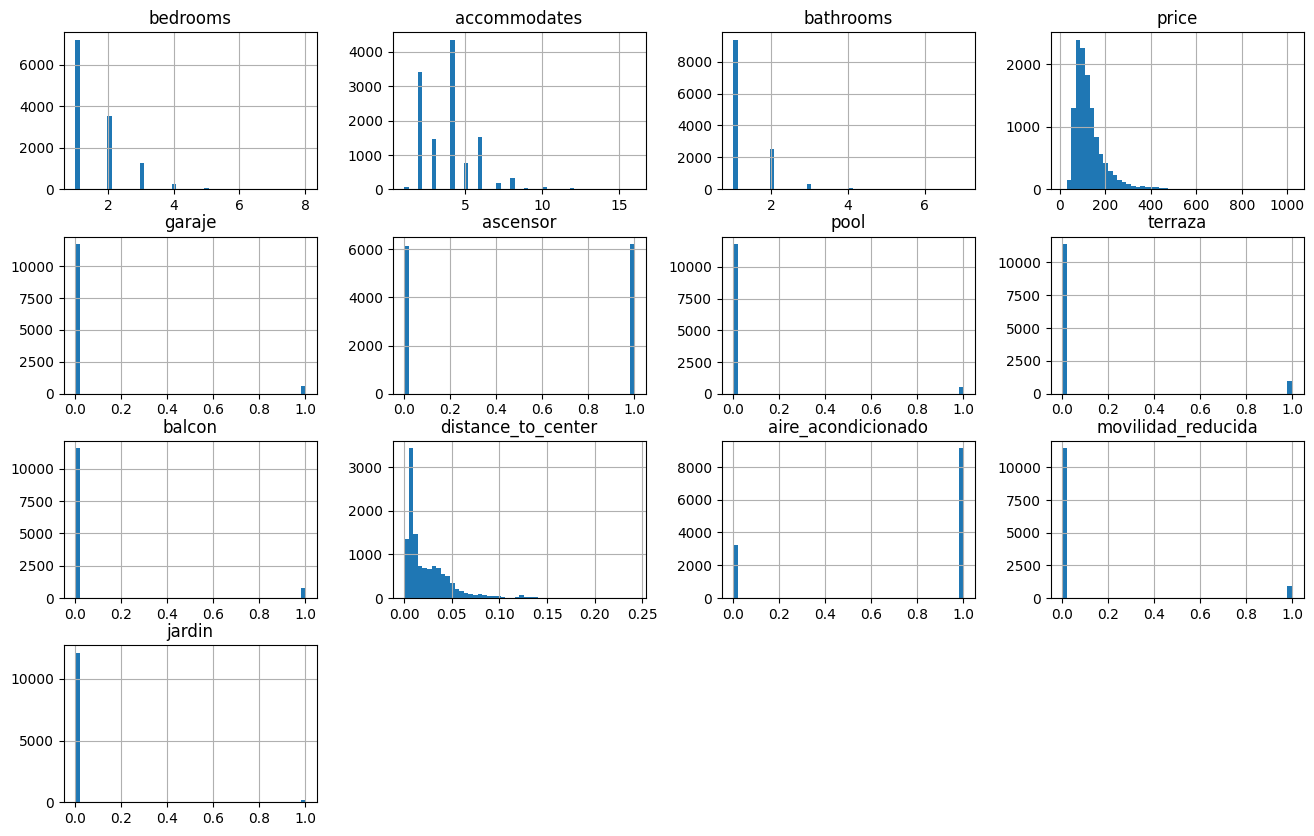

In [ ]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

In [ ]:
dfm.shape

(12347, 14)

In [ ]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.8734162 , -0.5702148 ,  0.53712947, ..., -0.38565742,
       -0.42520543, -0.8734162 ])

In [ ]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [ ]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12078, 14)

{'whiskers': [<matplotlib.lines.Line2D at 0x322182410>,
 'caps': [<matplotlib.lines.Line2D at 0x328052710>,
 'boxes': [<matplotlib.lines.Line2D at 0x3336a7690>],
 'medians': [<matplotlib.lines.Line2D at 0x328052410>],
 'fliers': [<matplotlib.lines.Line2D at 0x32a3d8d10>],
 'means': []}

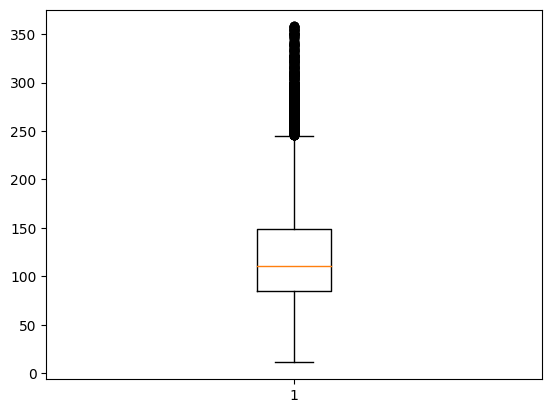

In [ ]:
plt.boxplot(dfm["price"])

In [ ]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [ ]:


numerical_features = ['bedrooms','bathrooms','distance_to_center']#X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
model = linear_model.Ridge(alpha=9.3)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [ ]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4960756126808208 mse: 1576.7772361252332 rmse: 39.70865442350362 mape: 0.2536735320177359


In [ ]:
# # Extract names from one-hot encoded categorical features
# num_features = ['bedrooms','bathrooms','accommodates','garaje','ascensor','aire_acondicionado','pool','terraza','balcon']
# cat_encoder = preprocessor.named_transformers_['cat']
# cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)


# # Combine all names
# feature_names = num_features + list(cat_feature_names)

# # 6. Create a DataFrame with coefficients
# coef_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Coefficient': model.coef_
# }).sort_values(by='Coefficient', key=np.abs, ascending=False)

# # 7. Show top features
# print(coef_df)

In [ ]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-39.61905848 -40.41265915 -38.63093588 -40.0592004  -40.2412716 ]
Média métricas de validación cruzada: -39.792625101456494


In [ ]:
# param_grid = {'alpha': [9.3],
#               'epsilon': np.arange(1,1.35,0.01)}
# model = linear_model.HuberRegressor()
# # Búsqueda por validación cruzada
# grid = GridSearchCV(
#         estimator  = model,
#         param_grid = param_grid,
#         scoring    = 'neg_root_mean_squared_error',
#         n_jobs     = -1,
#         cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
#         # verbose    = 0,
#         return_train_score = True
#     )

# grid.fit(X = X_train, y = y_train)

# # Resultados del grid
# resultados = pd.DataFrame(grid.cv_results_)
# resultados.filter(regex = '(param.*|mean_t|std_t)')\
#     .drop(columns = 'params')\
#     .sort_values('mean_test_score', ascending = False)

In [ ]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


,r2,mse,rmse,mape
lr,0.484806,1633.578054,40.417546,0.253995
ridge,0.484806,1633.578054,40.417546,0.253995
lasso,0.469220,1682.999156,41.024373,0.259687
SGD,0.483151,1638.826494,40.482422,0.266828
HuberRegressor,0.473721,1668.726385,40.850048,0.242373
Elastic,0.441942,1769.491300,42.065322,0.270827
XGBRegressor,0.516450,1533.242252,39.156637,0.240998


### Model 008

In [ ]:
dfm = df.copy()

In [ ]:
dfm.shape

(12347, 25)

In [ ]:
#'jardin','garaje'
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','calefaccion']]

In [ ]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.8734162 , -0.5702148 ,  0.53712947, ..., -0.38565742,
       -0.42520543, -0.8734162 ])

In [ ]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [ ]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12078, 13)

In [ ]:
dfm.dtypes

bedrooms                int64
accommodates            int64
bathrooms               int64
price                 float64
renta_bin              object
ascensor                int64
pool                    int64
terraza                 int64
balcon                  int64
distance_to_center    float64
aire_acondicionado      int64
movilidad_reducida      int64
calefaccion             int64
dtype: object

In [ ]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [ ]:


numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
model = XGBRegressor()
reg_cv = GridSearchCV(model, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [1.0], 'max_depth': [3, 4, 6],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [ ]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.2,
 'n_estimators': 500}

In [ ]:
model = XGBRegressor(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [ ]:

num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)


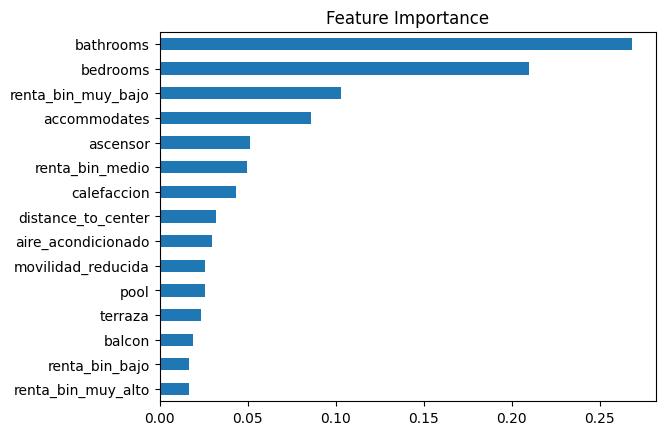

In [ ]:
feature_importance = pd.Series(model.feature_importances_, index=feature_names)
feature_importance.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [ ]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.6389803876346187 mse: 1129.628811181021 rmse: 33.60995107376714 mape: 0.21763036911625944


In [ ]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-40.08775571 -40.38564663 -37.89774068 -40.11096266 -40.20193458]
Média métricas de validación cruzada: -39.73680805000868


In [ ]:
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [ ]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.5248064431569127 mse: 1506.7455786266535 rmse: 38.81682082070418 mape: 0.24132518365535566


In [ ]:
train_predict_analysis.head(20)

,y,y_pred
24461,103.0,91.048584
14899,105.0,149.849335
24069,58.0,80.982719
7775,82.0,100.844696
13945,131.0,147.468719
3746,70.0,86.652939
11840,126.0,119.819412
16504,153.0,137.156982
9820,96.0,129.161118
12778,205.0,124.727745


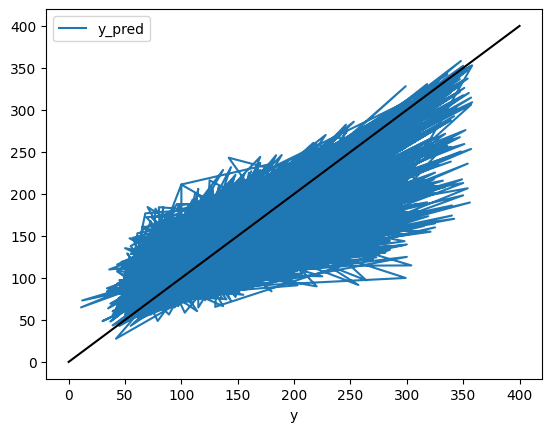

In [ ]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

In [ ]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

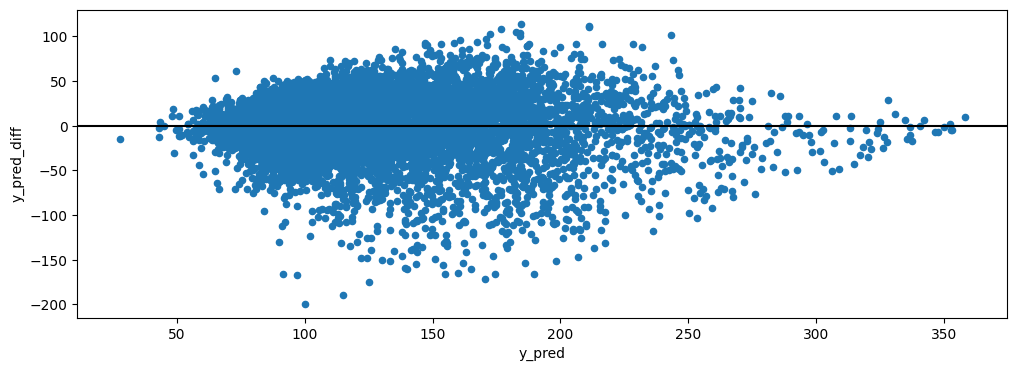

In [ ]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

<Axes: ylabel='Frequency'>

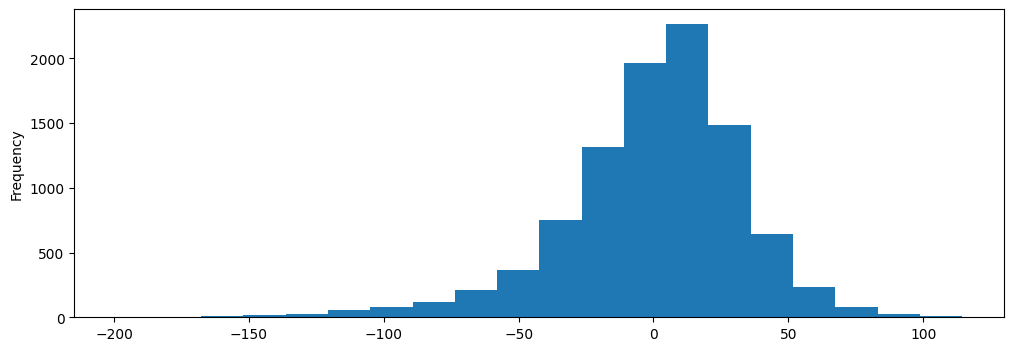

In [ ]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis["y_pred_diff"].plot.hist(bins=20)

Mismo modelo que Model008 pero añadiendo la columna distancia a estacion del metro y modelo SVR


In [ ]:
dfm = df.copy()

In [ ]:
dfm.shape

(12347, 25)

In [ ]:
#'jardin','garaje'
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','calefaccion','nearest_metro_distance']]

In [ ]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.8734162 , -0.5702148 ,  0.53712947, ..., -0.38565742,
       -0.42520543, -0.8734162 ])

In [ ]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [ ]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12078, 14)

In [ ]:
dfm.dtypes

bedrooms                    int64
accommodates                int64
bathrooms                   int64
price                     float64
renta_bin                  object
ascensor                    int64
pool                        int64
terraza                     int64
balcon                      int64
distance_to_center        float64
aire_acondicionado          int64
movilidad_reducida          int64
calefaccion                 int64
nearest_metro_distance    float64
dtype: object

In [ ]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [ ]:


numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


,r2,mse,rmse,mape
lr,0.483897,1636.461750,40.453204,0.254410
ridge,0.483897,1636.461750,40.453204,0.254410
lasso,0.473672,1668.881694,40.851948,0.257957
SGD,0.482500,1640.889476,40.507894,0.254774
HuberRegressor,0.472778,1671.718543,40.886655,0.242682
Elastic,0.449677,1744.965652,41.772786,0.269348
XGBRegressor,0.496507,1596.476035,39.955926,0.248419


In [ ]:
from sklearn.svm import SVR
#model = SVR(kernel='rbf', C=1.0, epsilon=0.1,gamma=0.1)
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
#reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3],"gamma":[0.1,0.2,0.3]}, verbose=1)
reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=SVR(kernel='linear'),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [ ]:
reg_cv.best_params_

{'C': 10.0, 'epsilon': 0.2}

In [ ]:
model = SVR(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [ ]:

num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)


In [ ]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.5087211926180526 mse: 1537.2092710011327 rmse: 39.20726043733651 mape: 0.22530742009763155


In [ ]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-40.20964853 -40.90428899 -39.63691999 -39.90310874 -41.07814054]
Média métricas de validación cruzada: -40.34642135802114


In [ ]:
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [ ]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4804051879421467 mse: 1647.5332513905198 rmse: 40.589817089887454 mape: 0.23296305354207808


In [ ]:
train_predict_analysis.head(20)

,y,y_pred
24461,103.0,74.904959
14899,105.0,157.188322
24069,58.0,101.725010
7775,82.0,96.785314
13945,131.0,137.823377
3746,70.0,87.730139
11840,126.0,108.671462
16504,153.0,132.181040
9820,96.0,137.369348
12778,205.0,109.495393


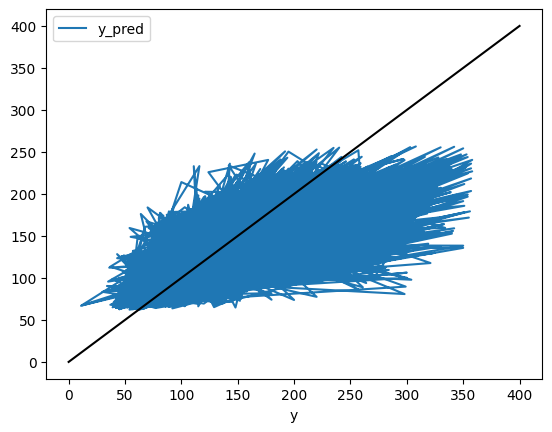

In [ ]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

In [ ]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

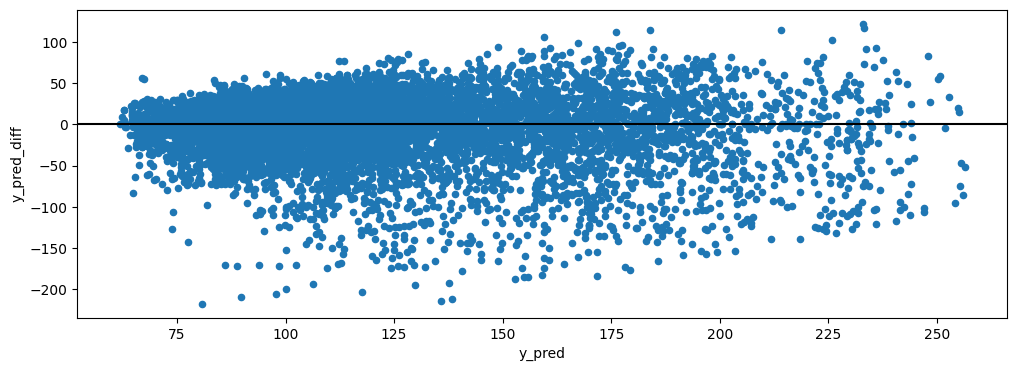

In [ ]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")